 This notebook includes implementations of [Mask R-CNN](https://arxiv.org/pdf/1703.06870v3.pdf) for detection and segmentation of pedestrian crossings in aerial images from city of Helsinki. This implementation of Mask R-CNN is developed by [Matterport](https://github.com/matterport/Mask_RCNN)

In [1]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import load_model


from os import listdir
from xml.etree import ElementTree

%matplotlib inline


# https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/
# https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d
# summary and notes : https://www.shortscience.org/paper?bibtexKey=journals/corr/HeGDG17#aleju
# main paper : https://arxiv.org/pdf/1703.06870v3.pdf

# https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46


Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.__version__

'1.3.0'

In [6]:
class CrossingDataset(Dataset):
    #https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d

    # # load the dataset definitions
    def load_dataset(self,  dataset_dir, is_train=True):

         # Add classes. We have two classes to add.
        self.add_class('dataset', 1, 'c')
        self.add_class('dataset', 2, 'n')
        
        # define data locations
        if is_train:
            images_dir = dataset_dir + '/image/'
            annotations_dir = dataset_dir + '/annot/'
        else:
            images_dir = dataset_dir + '/image/'
            annotations_dir = dataset_dir + '/annot/'
            

        # Iterate through all files in the folder to add class, images and annotaions
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            img_path = images_dir + image_id + '.png'
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        # extract the true class labels 
        labels = list()
        for label in root.findall('.//object'):
            label_ = label.find('name').text
            #classes.append(label)
            labels.append(label_)
            
        return boxes, width, height, labels


    # load the masks for an image
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h , labels = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(labels[i]))
        return masks, asarray(class_ids, dtype='int32')



    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']


In [7]:
#  prepare train set
train_set = CrossingDataset()
train_set.load_dataset('./LABEL_IMG/hel_espoo_images/train', is_train=True)
train_set.prepare()
print('Number of images in train set is {}'.format(len(train_set.image_ids)))

Number of images in train set is 2360


In [8]:
#  prepare test set 
test_set = CrossingDataset()
test_set.load_dataset('./LABEL_IMG/hel_espoo_images/test', is_train=False)
test_set.prepare()
print('Number of images in test set is {}'.format(len(test_set.image_ids)))

Number of images in test set is 114


In [9]:
# check dataset by loading image 
image_id = 5
image = train_set.load_image(image_id)
print(image.shape)

(500, 500, 3)


In [10]:
train_set.image_reference(image_id)

'./LABEL_IMG/hel_espoo_images/train/image/train_1582.png'

In [11]:
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
print(class_ids)

(500, 500, 5)
[1 1 1 1 1]


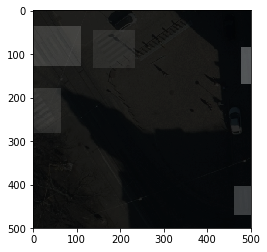

In [12]:
plt.imshow(image)
    # plot all masks
for j in range(mask.shape[2]):
    plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)

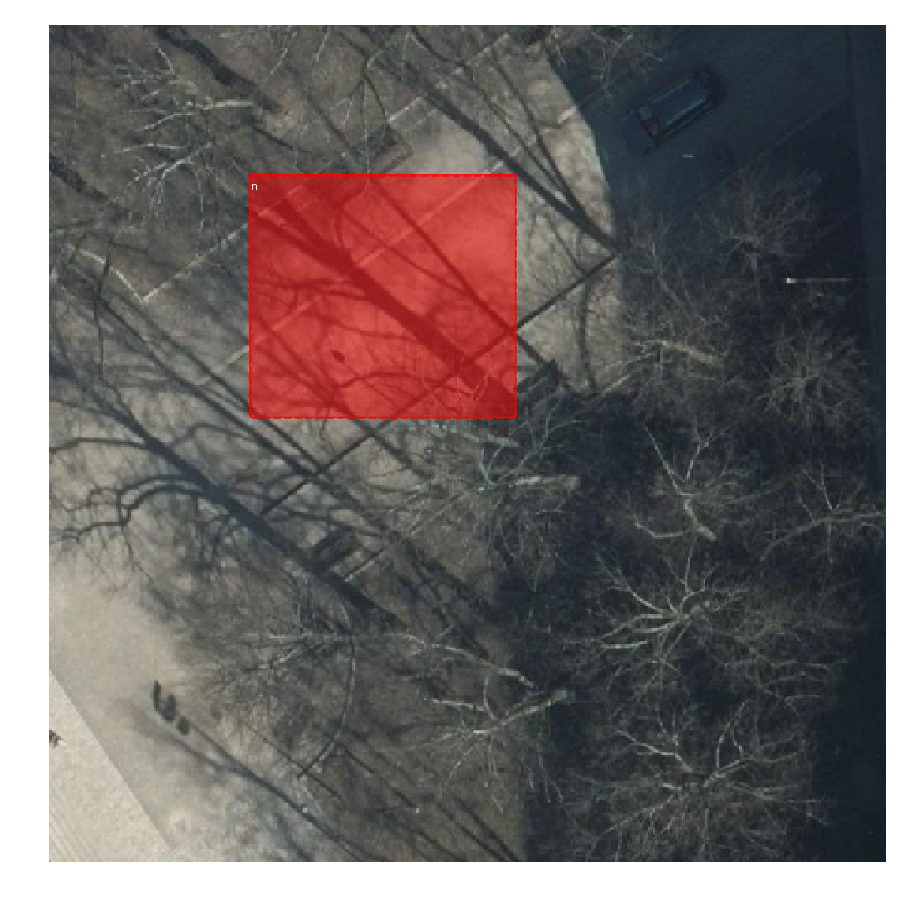

In [15]:
# define image id
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [16]:
# enumerate all images in the dataset
#count = 0
#for image_id in train_set.image_ids:
 #   # load image info
  #  info = train_set.image_info[image_id]
   # count +=1
    # display on the console
    #print(info)
#print(count)


In [17]:
class CrossingConfig(Config):
    NAME = "crossings_cfg"
    # Number of classes (background + crossings+ no_crossings )
    NUM_CLASSES = 1+1+1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 120
    DETECTION_MIN_CONFIDENCE = 0.90
     # setting Max ground truth instances
    MAX_GT_INSTANCES=5
 
# prepare config
config = CrossingConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [12]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

In [13]:
# load weights (mscoco)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [16]:
# AttributeError: module 'tensorflow' has no attribute 'log', 

In [ ]:
# train weights (output layers or 'heads')
model.train(train_set, test_set , learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./crossings_cfg20200105T1348/mask_rcnn_crossings_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4       

/home/jyoti/anaconda3/envs/test/lib/python3.4/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### Evaluating the Model

In [27]:
class PredictionConfig(Config):
    NAME = "crossings_cfg20200105T1348"
    # Number of classes (background + crossings+ no_crossings )
    NUM_CLASSES = 1 + 1 + 1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 120
    DETECTION_MIN_CONFIDENCE = 0.85
     # setting Max ground truth insances
    MAX_GT_INSTANCES=5
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
cfg = PredictionConfig()


In [28]:
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights('mask_rcnn_crossings_confidence_85_0043.h5', by_name=True)

In [28]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
    # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = np.mean(APs)
    return mAP

In [ ]:
# evaluate model on training and test set dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.2f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.2f" % test_mAP)

###  Detection and segmentation of crossing from images 

In [29]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [30]:
img = load_img('./LABEL_IMG/test/images/train_31.png')

In [31]:
%%time
img = img_to_array(img)
# detecting objects in the image
result= model.detect([img])

CPU times: user 1min 48s, sys: 2.26 s, total: 1min 50s
Wall time: 29.1 s


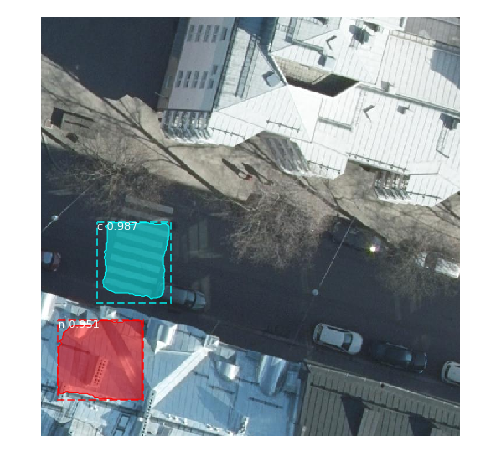

CPU times: user 610 ms, sys: 100 ms, total: 710 ms
Wall time: 477 ms


In [33]:
%%time
r = result[0]
tt = visualize.display_instances(img, r['rois'], r['masks'],r['class_ids'],test_set.class_names, r['scores'],figsize=(8,8))

In [59]:
train_set.class_names

['BG', 'c', 'n']

In [28]:
r['rois']

array([[192, 145, 228, 184],
       [ 89,  70, 198, 123],
       [107, 183, 165, 241],
       [ 64,  81, 126, 130],
       [ 76, 181, 129, 234],
       [140, 189, 195, 231]], dtype=int32)